In [1]:
from tetris import Tetris
from random import randint

In [2]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc, colors, image
from IPython.display import HTML

Visualize game states:

In [3]:
def animate(states):
    'Creates animation from states list.'
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cmap = colors.ListedColormap(['black', 'red', 'blue'])
    norm = colors.Normalize(0, 2)
    ax.axis('off')
    images = []
    for state in states:
        well, score, is_game_over = state
        sc = ax.annotate(f"score: {score}",(1,19), color='white')
        image = ax.imshow(well, cmap=cmap, norm=norm)
        if is_game_over:
            go = ax.annotate("GAME OVER", (2, 10), color='white')
            images = images + ([[image, go] * 3, [image] * 3] * 10)
            break
        images.append([image, sc])

    return animation.ArtistAnimation(fig, images, interval=50, blit=True,
                                    repeat_delay=1000)


In [4]:
def play(player):
    'Plays tetris with player and returns list of states.'
    tetris = Tetris()
    states = [tetris.step(0)]
    is_game_over = False
    while not is_game_over:
        state = tetris.step(player(states[-1][0]))
        states.append(state)
        _,_,is_game_over = state
    return states

In [5]:
def random_player(well):
    'Returns random action.'
    return randint(0, 4)

In [6]:
states = play(random_player)

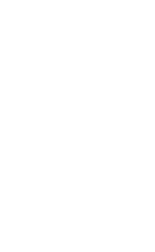

In [7]:
ani = animate(states)

In [8]:
HTML(ani.to_html5_video())

Start very deep learning:

In [9]:
import numpy as np
import os
import random
import tensorflow as tf

/home/max/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [10]:
def gather_columns(params, indices):
    # prepare row indices
    row_indices = tf.range(tf.shape(indices)[0])
    # zip row indices with column indices
    full_indices = tf.stack([row_indices, indices], axis=1)
    # retrieve values by indices
    return tf.gather_nd(params, full_indices)

Q-function:

In [11]:
def build_q_function(resolution, n_actions):
    with tf.variable_scope("Q_function"):
        well_pl = tf.placeholder(shape=[None] + resolution + [2], dtype=tf.float32, name="well")
        reward_pl = tf.placeholder(shape=[None], dtype=tf.float32, name="reward")
        action_pl = tf.placeholder(shape=[None], dtype=tf.int32, name="action")
        
        conv_1 = tf.layers.conv2d(well_pl, 32, 4, strides=(1,1), activation=tf.nn.relu, name="conv_1")
        flatten = tf.contrib.layers.flatten(conv_1)
        dense1 = tf.layers.dense(flatten, 32 * resolution[0] * resolution[1] * 2, activation=tf.nn.relu, name="dense1")
        output = tf.layers.dense(dense1, n_actions, name="output")
        q_value = gather_columns(output, action_pl)
        loss = tf.losses.mean_squared_error(reward_pl, q_value)
        train_op = tf.train.AdamOptimizer().minimize(loss, global_step=tf.train.get_or_create_global_step())
        
        return (well_pl, reward_pl, action_pl), (output, loss, train_op)        

Predict function:

In [12]:
def build_estimator(sess, well_pl, output):
    
    def estimate(sess, well_pl, output, wells):
        feed_dict = { 
            well_pl: wells
        }
        return sess.run([output], feed_dict)
    
    def estimator(wells):
        return estimate(sess, well_pl, output, wells)
    
    return estimator;

Train function:

In [13]:
def build_trainer(sess, well_pl, action_pl, reward_pl, loss, train_op):
    
    def train(sess, well_pl, reward_pl, action_pl, loss, train_op, wells, actions, rewards):
        feed_dict = { 
            well_pl: wells,
            reward_pl: rewards,
            action_pl: actions
        }
        
        return sess.run([loss, train_op, tf.train.get_or_create_global_step()], feed_dict)
    
    def trainer(wells, actions, rewards):
        return train(sess, well_pl, reward_pl, action_pl, 
                        loss, train_op, wells, actions, rewards)[0]
    
    return trainer;

Split well to channel with figure and channel with trash:

In [14]:
def preprocess(well):
    return np.array([[[v == 1, v == 2] for v in row] for row in well], dtype=float)

Initialize model:

In [15]:
tf.reset_default_graph()
(well_pl, reward_pl, action_pl), (output, loss, train_op) = build_q_function([20, 10], 5)

In [16]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [17]:
estimate = build_estimator(sess, well_pl, output)
train = build_trainer(sess, well_pl, action_pl, reward_pl, loss, train_op)

Learning session:
    eps - random action probability
    gamma - discount factor

In [18]:
def learn(estimate, train, eps, gamma, replay_capacity, batch_size, episode_n, steps_n):
    
    def prepare_batch(D):
        indices = np.random.choice(len(D), min(batch_size, len(D)), replace=False)
        X = [D[i][0] for i in indices]
        X_next = [D[i][3] for i in indices]
        actions = [D[i][2] for i in indices]
        terminal_flags = np.array([D[i][4] for i in indices], dtype = float)
        rewards = np.array([D[i][2] for i in indices])
        q_values = np.squeeze(np.max(estimate(X_next), axis=-1))
        y_train = rewards + q_values * terminal_flags
        return X, actions, y_train
    
    def calc_free_rows(x):
        garbage_channel = x[0]
        for i in range(len(garbage_channel)):
            if sum(garbage_channel[i]) > 0:
                return i
        return i
    
    D = []
    max_score = 0
    replay_index = 0
    for i in range(episode_n):
        tetris = Tetris()
        well, score, _ = tetris.step(0)
        x = preprocess(well)
        free_rows = calc_free_rows(x)
        for j in range(steps_n):
            if np.random.rand() < eps:
                a = randint(0, 4)
            else:
                a = np.argmax(estimate([x]))
            well, new_score, is_game_over = tetris.step(a)
            new_x = preprocess(well)
            new_free_rows = calc_free_rows(new_x)
            r = float(new_score - score) / 10.0 + 1.0 if free_rows >= new_free_rows else 0.0
            score = new_score
            replay_entry = (x, a, r, new_x, is_game_over)
            x = new_x
            # fill replay buffer
            if len(D) < replay_capacity:
                D.append(replay_entry)
            else:
                # ring buffer for replays
                D[replay_index] = replay_entry
                replay_index == replay_index + 1
                if replay_index >= replay_capacity:
                    replay_index = 0
            states_train, actions_train, rewards_train = prepare_batch(D) 
            loss = train(states_train, actions_train, rewards_train)
            print(f"Episode {i}, step: {j}, score: {score}, max score: {max_score}, loss: {loss:.3}", end='\r')
            if is_game_over:
                break
        max_score = max(max_score, score)
    return

Start session:

In [19]:
learn(estimate, train, eps=0.5, gamma=0.9, replay_capacity=1000, batch_size=32, episode_n=100, steps_n=1000)

Check how model plays:

In [20]:
def neuro_player(well):
    'Returns model predicted action.'
    return np.argmax(estimate([preprocess(well)]))

In [21]:
states = play(neuro_player)

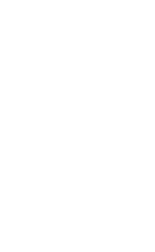

In [22]:
ani = animate(states)

In [23]:
HTML(ani.to_html5_video())